# Import and Process SHG Data

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import math

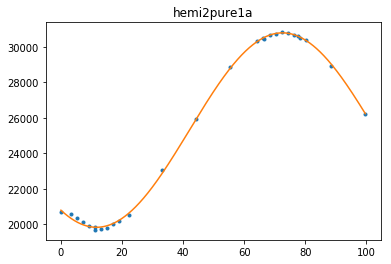

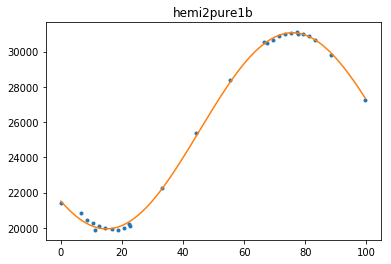

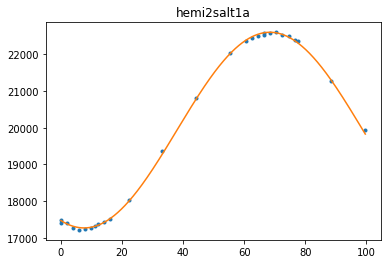

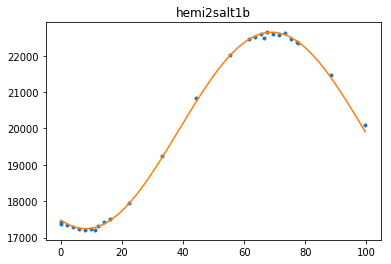

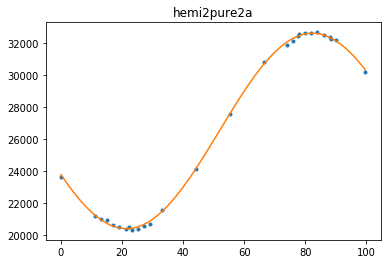

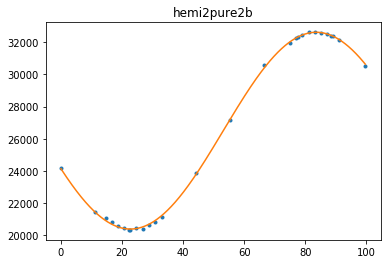

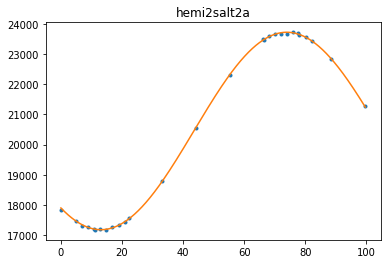

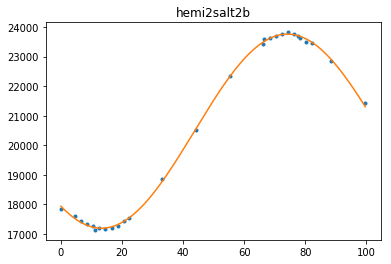

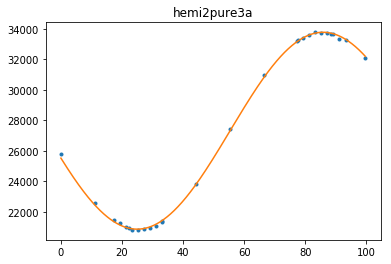

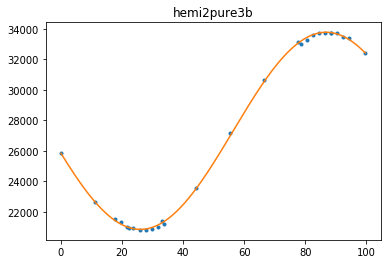

In [13]:
#location of data files
inputpath = '/Users/geiger/Box Sync/Science/Data/SHG/2018/101618'

#name and path of output file
outputpath = '/Users/geiger/Box Sync/Science/Data/SHG/2018/101618'



#names of each fit
names = 'hemi2pure1a'

fileout = 'testOutput.txt'

#indices to import if you have multiple files named phaseMeasureX where x is 
#some number, enter the first and last indices that you want to import.
startNum = 16
endNum = 25

#open file for writing to
f = open(fileout,'w+')

#initialize data frames to hold data
countsA = pd.DataFrame()
countsB = pd.DataFrame()
pos = pd.DataFrame()

#go through each file
for i in range(endNum-startNum+1):
    #names of each file
    filename = inputpath + '/phaseMeasure' + str(i+startNum) + '.txt'
    #import countsA (signal),countsB (dark counts), and pos (stage position)
    countsA[names[i]] = pd.read_csv(filename,sep='\t')['countsA']
    countsB[names[i]] = pd.read_csv(filename,sep='\t')['countsB']
    pos[names[i]] = pd.read_csv(filename,sep='\t')['stage']
    
    #function to find the av
def findAverage(series):
    #set number of points per position here
    interval = 20
    reshaped = np.reshape(series.values,(int(len(series.values)/interval),interval))
    return pd.Series(np.mean(reshaped,1))

#apply function to raw data to get average data
aveCountsA = countsA.apply(findAverage,axis=0)
aveCountsB = countsB.apply(findAverage,axis=0)
pos = pos.apply(findAverage,axis=0)
del countsA,countsB

#sort each 
for column in pos.columns:
    #create temp dataframe
    df = pd.DataFrame()
    #import data frome one run into temp data frame
    df['countsA'] = aveCountsA[column]
    df['countsB'] = aveCountsB[column]
    df['pos'] = pos[column]
    #sort this dataframe
    sdf = df.sort_values('pos')
    #put the sorted data back
    aveCountsA[column] = sdf['countsA'].values
    aveCountsB[column] = sdf['countsB'].values
    pos[column] = sdf['pos'].values
    del df,sdf, column
    
    #dataframe with actual counts, corrected for dark counts
counts = aveCountsA.sub(aveCountsB)
del aveCountsA,aveCountsB


#define fit func, same as IGOR
def sinFunc(x, y0, A, f, phi):
    return y0 + A*np.sin(f*x + phi)


#DO INITIAL FITTING WITH PERIODS FREE 
#x values from which to plot fit function
xvalues = np.linspace(0,99.7,1000)
#write header for initial fits to file
f.write('Initial Fits\n')
f.write('Name\ty0\tA\tf\tphi\n')
#array to store the frequencies from each fit, in order to then find the average
fVals = np.array([])
#go through each column in dataframe
for column in counts.columns:
    #calculate guesses for fit func
    y0guess = np.mean(counts[column])
    Aguess = (np.amax(counts[column])-np.amin(counts[column]))/2
    fguess = 0.05;
    phiguess = 0;
    guesses = [y0guess,Aguess,fguess,phiguess]
    
    #fit it
    popt, pcov = curve_fit(sinFunc,pos[column],
                           counts[column],p0=guesses)
    #calculate standard error
    pstd = np.sqrt(np.diag(pcov))
#    plt.figure()
#    plt.plot(pos[column],counts[column],'.')
#    yvalues = sinFunc(xvalues,popt[0],popt[1],popt[2],popt[3])
#    plt.plot(xvalues,yvalues)
#    plt.title('First' + column)
    #write to file
    f.write(column + '\t' +'%.1f'%popt[0] +'+-'+'%.1f'%pstd[0]+
          '\t'+'%.1f'%popt[1]+'+-'+'%.1f'%pstd[1]+
          '\t'+'%.4f'%popt[2]+'+-'+'%.4f'%pstd[2]+
          '\t'+'%.3f'%popt[3]+'+-'+'%.3f'%pstd[3]+'\n')
    fVals = np.append(fVals,popt[2])

#calculate average of f values, write to file
fAve = np.mean(fVals)
fStd = np.std(fVals)
f.write('\n')
f.write('f = '+'%.4f'%fAve+'+-'+'%.4f'%fStd+
        '('+'%.0f'%(fStd/fAve*100)+'% error)'+'\n')
f.write('lambda ='+'%.2f'%(2*np.pi/fAve)+'+-'+
        '%.2f'%(2*np.pi/fAve*fStd/fAve)+'\n')
f.write('\n')


#SECOND ROUND OF FITTING WITH PERIOD FIXED AT AVERAGE OF PREVIOUS
#write header
f.write('Fits with f fixed\n')
f.write('Name\ty0\tA\tf\tphi\tphi(degrees)\n')
#array to store the y0s to normalize
y0s = {}
#x values from which to plot fit function
xvalues = np.linspace(0,99.7,1000)
fits = pd.DataFrame()
#go through each column
for column in counts.columns:
    #calculate guesses
    y0guess = np.mean(counts[column])
    Aguess = (np.amax(counts[column])-np.amin(counts[column]))/2
    phiguess = 0;
    guesses = [y0guess,Aguess,phiguess]

    #fit it
    popt, pcov = curve_fit(lambda x, y0, A, 
                           phi: sinFunc(x,y0, A, fAve, phi),
                           pos[column],counts[column],p0=guesses)
    #calculate standard error
    pstd = np.sqrt(np.diag(pcov))
    #write data to file
    f.write(column+'\t'+'%.1f'%popt[0]+'+-'+'%.1f'%pstd[0]+
          '\t'+'%.1f'%popt[1]+'+-'+'%.1f'%pstd[1]+
          '\t'+'%.4f'%fAve+'+-'+'%.4f'%fStd+
          '\t'+'%.3f'%popt[2]+'+-'+'%.3f'%pstd[2]+
          '\t'+'%.1f'%np.degrees(popt[2])+'+-'+
          '%.1f'%np.degrees(pstd[2])+'\n')
    
    y0s[column] = popt[0]
    fits[column] = sinFunc(xvalues,popt[0],popt[1],fAve,popt[2])
    #plot each fit
    plt.figure()
    plt.plot(pos[column],counts[column],'.')
    plt.plot(xvalues,sinFunc(xvalues,
             popt[0],popt[1],fAve,popt[2]))
    plt.title(column)



#create a copy and normalize by their y0 values        
countsNorm = counts.copy()
fitsNorm = fits.copy()
for column in countsNorm.columns:
    countsNorm[column] = counts[column]/y0s[column]
    fitsNorm[column] = fits[column]/y0s[column]
countsNorm = countsNorm.add_suffix('Norm')

fits = fits.add_prefix('fits_')
fitsNorm = fitsNorm.add_prefix('fitsNorm_')
pos = pos.add_suffix('Pos')
 
#close file       
f.close()
